# 線形混合効果モデル

線型混合効果モデルを使うことで　　、カテゴリカルなものからのものまで様々なタイプの入力データ点と結合されたものから実数値の出力との間の線形な関係をモデル化したいと思います。ここではEdwardでの例をJupyterで示します。

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal
from observations import insteval

plt.style.use('ggplot')
ed.set_seed(42)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data

[lme4 R パッケージ](http://lme4.r-forge.r-project.org/) (Bates, Mächler, Bolker, & Walker, 2015)の`InstEval`というデータセットをここでは用います。

これはインストラクターの評価の順位づけのデータで入力(covariates)が
生徒（`students`）や教科(`departments`)のようにカテゴライズされており、ここで我々が興味を持つ応答変数はインストラクターの評価の順位です。

In [5]:
data, metadata = insteval("data")
data = pd.DataFrame(data, columns=metadata['columns'])

# s - students - 1:2972
# d - instructors - codes that need to be remapped
# dept also needs to be remapped
data['s'] = data['s'] - 1
data['dcodes'] = data['d'].astype('category').cat.codes
data['deptcodes'] = data['dept'].astype('category').cat.codes
data['y'] = data['y'].values.astype(float)

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

>> Downloading data/InstEval.csv
>> [560.5 KB/560.5 KB] 182% @5.7 MB/s,[0s remaining, 0s elapsed]        

,s,d,studage,lectage,service,dept,y,dcodes,deptcodes
66702,2714,474,8,5,1,1,4.0,248,0
51671,2074,102,8,1,1,1,2.0,55,0
35762,1456,139,6,4,0,12,2.0,73,11
43777,1772,2096,8,3,0,10,4.0,1092,9
4788,178,554,6,6,1,6,5.0,290,5


データセットは
+ `students` as `s`
+ `instructors` as `d`
+ `departments` as `dept`
+ `service` as `service`

という構成になっています。

In [8]:
s_train = train['s'].values
d_train = train['dcodes'].values
dept_train = train['deptcodes'].values
y_train = train['y'].values
service_train = train['service'].values
n_obs_train = train.shape[0]

s_test = test['s'].values
d_test = test['dcodes'].values
dept_test = test['deptcodes'].values
y_test = test['y'].values
service_test = test['service'].values
n_obs_test = test.shape[0]

In [10]:
n_s = max(s_train) + 1  # number of students
n_d = max(d_train) + 1  # number of instructors
n_dept = max(dept_train) + 1  # number of departments
n_obs = train.shape[0]  # number of observations

print("Number of students: {}".format(n_s))
print("Number of instructors: {}".format(n_d))
print("Number of departments: {}".format(n_dept))
print("Number of observations: {}".format(n_obs))

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


# Model

線型回帰ではそれぞれのデータ点は共通した定数の傾きを持つという独立した仮定を置いています。
ここではそうではなく傾きと切片にばらつきを持つようなグループからデータが観測されることを仮定します。
このような振る舞いを捉えることのできるモデルを作ろうと思います(Gelman & Hill, 2006)。

この現象の例としては
+　一人一人の生徒の評価結果が独立でない。特定の生徒が低い(あるいは高い)授業の評価をしがちである。
+ 一人一人の講師に対する評価結果が独立でない。良い講師講師は高い評価をもらい、悪い講師は低い評価をもらうことが予想できる。
+ それぞれの教科に対する評価結果は独立ではない。ある教科は他よりも淡白な教材を使っておりそれゆえに他より評価が低い可能性がある。

といった場合があります。

典型的な線型回帰モデルは以下のような形をしています。

\begin{equation*}
\mathbf{y} = \mathbf{X}\beta + \epsilon,　\\
\epsilon\sim\mathcal{N}(\mathbf{0}, \mathbf{I})
\end{equation*}

ここで$\mathbf{X}$ は固定係数による効果を表し、
$\beta$ と $\epsilon$ はランダムノイズを表しています。

線型混合モデルではこれに加えて係数$\eta$に従うランダムな効果$\mathbf{Z}$として
$\mathbf{Z}\eta$, where $\mathbf{Z}$ corresponds to random effects
モデルは全体として

\begin{align*}
\eta &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}), \\
\mathbf{y} &= \mathbf{X}\beta + \mathbf{Z}\eta + \epsilon.
\end{align*}

与えられたデータに対して(解析の)ゴールはモデルの("固定効果")パラメータ$\beta$, 隠れた変数("ランダム効果")$\eta$, 分散要素のパラメータ$\sigma^2$を推定することです。

ランダム効果の平均値は0なのでデータの平均は$\mathbf{X}\beta$で表現されます。 $\mathbf{Z}\eta$のランダムさはデータのばらつきを捉えるものになります。(例えば講師\#54のレートは1.4で平均より高い）

固定の効果とランダムな効果の間には自然に疑問が生じます。固定効果は与えられた人々に対し一定です。ランダム効果は与えられた人々に対して変動します。
(即ち一部の人々の間には定数だがそのほかの人々の間では値が変動するということがありうる。)これを以下の例で図示します。

+ `service`を固定の効果として選びます。これは２値の共変量である講義が担当講師のメインの教科に属しているかどうかを示します。
どんなに多くのデータを集めてもこの値は$0$ と $1$の２値しか取り得ません。
+ カテゴリカル変数である`students`, `teachers`, `departments`をランダム効果として選びます。より多くの観測を講師の評価する人たちに対して行うと新たな生徒、講師、教科が得られることでしょう。

Rのlme4パッケージ(Bates et al., 2015)の文法ではモデルは
```
y ~ 1 + (1|students) + (1|instructor) + (1|dept) + service
```
と簡潔に記述することができます。ここで'1'は切片の項、'(1|x)'はxのランダム効果ランダム効果そして'x'はxの固定効果を表します。

## modelのcode化

In [11]:
# 入力データのためのプレースホルダー
s_ph = tf.placeholder(tf.int32, [None])
d_ph = tf.placeholder(tf.int32, [None])
dept_ph = tf.placeholder(tf.int32, [None])
service_ph = tf.placeholder(tf.float32, [None])

# 固定効果
mu = tf.Variable(tf.random_normal([]))
service = tf.Variable(tf.random_normal([]))

sigma_s = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
sigma_d = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
sigma_dept = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))

# ランダム効果
eta_s = Normal(loc=tf.zeros(n_s), scale=sigma_s * tf.ones(n_s))
eta_d = Normal(loc=tf.zeros(n_d), scale=sigma_d * tf.ones(n_d))
eta_dept = Normal(loc=tf.zeros(n_dept), scale=sigma_dept * tf.ones(n_dept))

yhat = (tf.gather(eta_s, s_ph) +
        tf.gather(eta_d, d_ph) +
        tf.gather(eta_dept, dept_ph) +
        mu + service * service_ph)
y = Normal(loc=yhat, scale=tf.ones(n_obs))

# 推測処理

与えられたデータに対し、モデルの固定、ランダム効果の影響を推測します。
この解析では$\text{KL}(q\|p)$ divergenceを計量とした変分推論を用います。
完全に因子分解された正規近似をランダム効果の近似のために用い、
全ての訓練データを推測に用います。

このアルゴリズムでは固定効果は変分EMアルゴリズムのスキームの素で見積もられることになります。

In [12]:
q_eta_s = Normal(
    loc=tf.Variable(tf.random_normal([n_s])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_s]))))
q_eta_d = Normal(
    loc=tf.Variable(tf.random_normal([n_d])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_d]))))
q_eta_dept = Normal(
    loc=tf.Variable(tf.random_normal([n_dept])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_dept]))))

latent_vars = {
    eta_s: q_eta_s,
    eta_d: q_eta_d,
    eta_dept: q_eta_dept}
data = {
    y: y_train,
    s_ph: s_train,
    d_ph: d_train,
    dept_ph: dept_train,
    service_ph: service_train}

inference = ed.KLqp(latent_vars, data)

推測によりフィットしたしたモデルを評価する方法の一つは残渣プロット(residual plot)です。
これはそれぞれのデータ点に対し予測された値と観測された値の差をプロットするものです。
以下では手動で推測処理を行います。アルゴリズムの初期化とループ内の個々の更新(update)です。
残渣プロットをアルゴリズムが進むたびに描画します。これはどの程度アルゴリズムがデータからランダム効果、固定効果の
推測の処理を進めているのかを見極めるのに役立ちます。

残差を作るためにまずテストデータからの予測を行います。ここではモデルの中で定義された`yhat`をコピーし、
そのランダム効果による影響を推測された平均値で置き換えることで行います。このアルゴリズムの中でテスト入力に対する予測を評価します。

我々は`lme4`の中の同じモデル(`y ~ service + (1|dept) + (1|s) + (1|d)` 特に`InstEval` データセットに完全にフィットする)もフィットさせました。
そのモデルでのランダム効果の度合いを保存しており、それらと学習されたパラメータを比較することになるでしょう。


In [13]:
yhat_test = ed.copy(yhat, {
    eta_s: q_eta_s.mean(),
    eta_d: q_eta_d.mean(),
    eta_dept: q_eta_dept.mean()})

    1/10000 [  0%]                                ETA: 19770s | Loss: 519833.156

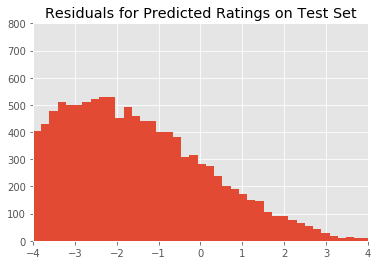

 2000/10000 [ 20%] ██████                         ETA: 38s | Loss: 97153.977    

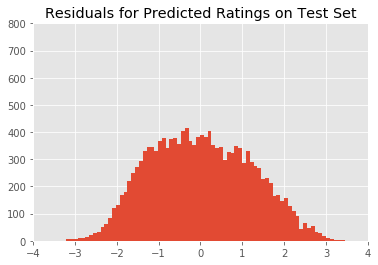

 4000/10000 [ 40%] ████████████                   ETA: 25s | Loss: 97134.023

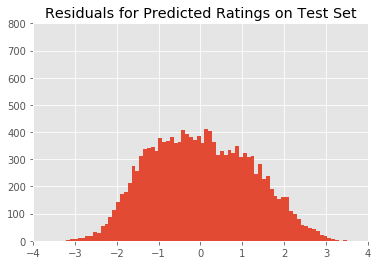

 6000/10000 [ 60%] ██████████████████             ETA: 16s | Loss: 97005.602

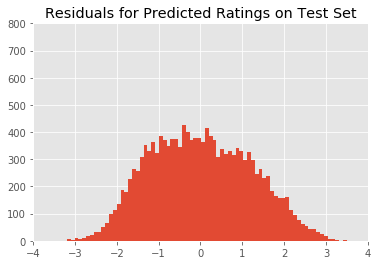

 8000/10000 [ 80%] ████████████████████████       ETA: 8s | Loss: 97081.656 

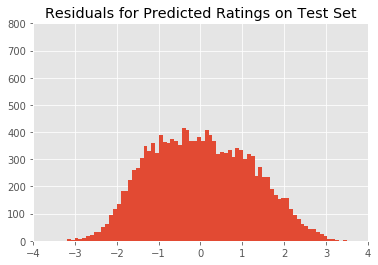

10000/10000 [100%] ██████████████████████████████ Elapsed: 39s | Loss: 97091.828


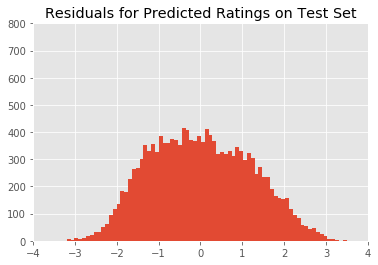

In [14]:
inference.initialize(n_print=2000, n_iter=10000)
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  # アップデートのたびに進捗を表示する
  info_dict = inference.update()
  inference.print_progress(info_dict)

  t = info_dict['t']
  if t == 1 or t % inference.n_print == 0:
    # テストデータに対する予測
    yhat_vals = yhat_test.eval(feed_dict={
        s_ph: s_test,
        d_ph: d_test,
        dept_ph: dept_test,
        service_ph: service_test})

    # 残差プロット
    plt.title("テスト集合で予測されたレーティングの残差")
    plt.xlim(-4, 4)
    plt.ylim(0, 800)
    plt.hist(yhat_vals - y_test, 75)
    plt.show()

# Criticism

上ではモデルがフィットしているかどうかを残差プロットを使って診断するための方法を示しました。　
アルゴリズムが最後に出力した残差プロットをみてくだだい。

残差は平均０の周囲の正規分布のように見えます。これはモデルにとっては良い健全性チェックの結果となっています。

ここで学習されたパラメータとRの`lme4`で推定された結果を比較することもできます。

In [15]:
student_effects_lme4 = pd.read_csv('data/insteval_student_ranefs_r.csv')
instructor_effects_lme4 = pd.read_csv('data/insteval_instructor_ranefs_r.csv')
dept_effects_lme4 = pd.read_csv('data/insteval_dept_ranefs_r.csv')

In [16]:
student_effects_edward = q_eta_s.mean().eval()
instructor_effects_edward = q_eta_d.mean().eval()
dept_effects_edward = q_eta_dept.mean().eval()

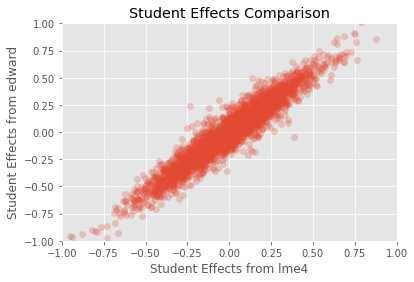

In [20]:
plt.title("Student Effects Comparison")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Student Effects from lme4")
plt.ylabel("Student Effects from edward")
plt.scatter(student_effects_lme4["(Intercept)"],
            student_effects_edward,
            alpha=0.25)
plt.show()

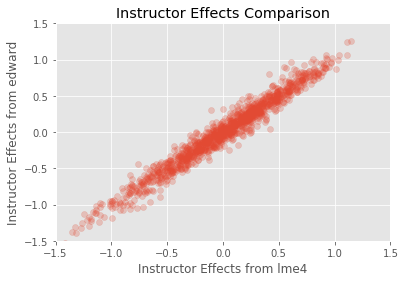

In [21]:
plt.title("Instructor Effects Comparison")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Instructor Effects from lme4")
plt.ylabel("Instructor Effects from edward")
plt.scatter(instructor_effects_lme4["(Intercept)"],
            instructor_effects_edward,
            alpha=0.25)
plt.show()

いいですね！生徒と講師双方の効果に関する我々の推定はlme4の結果と近いようです。
我々は少し違ったモデルをここでは採用しました(例えば全体平均が正規化されている、生徒、教科、講師に関する効果の分散、これらはlme4sのモデルをでは正しくない　)
また異なる推測の方法を使いました。ゆえにlme4と全く同じパラメータを期待することはできませn。しかし結果はよく一致しています！

In [22]:
#  Add in the intercept from R and edward
dept_effects_and_intercept_lme4 = 3.28259 + dept_effects_lme4["(Intercept)"]
dept_effects_and_intercept_edward = mu.eval() + dept_effects_edward

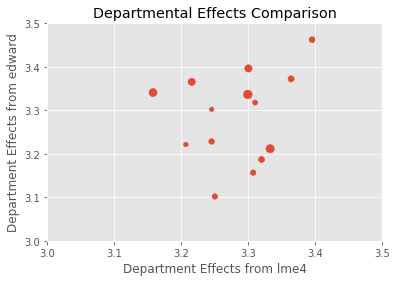

In [23]:
plt.title("Departmental Effects Comparison")
plt.xlim(3.0, 3.5)
plt.ylim(3.0, 3.5)
plt.xlabel("Department Effects from lme4")
plt.ylabel("Department Effects from edward")
plt.scatter(dept_effects_and_intercept_lme4,
            dept_effects_and_intercept_edward,
            s=0.01 * train.dept.value_counts())
plt.show()

我々の方法での教科の効果は`lme4`のものとはよく一致指定はいません。
これにはいくつかの理由が考えられます。
  *  我々の方法では全体の平均を正規化しており、`lme4`ではそうしていません。これはedwardのモデルが教科の効果を割り引くような効果をもたらします。
    そして我々のモデルでは分散の値も学習しているため変動がより広くなるような結果をもたらします。
  *  我々の方法では80%のデータをedwardのモデルの訓練に用いていますが、`lme4`では`InstEval`データセットの全体を用いています。
  * 教科の効果はモデルの中で最も弱く見積もりが困難です。

## 謝辞

このチュートリアルの最初のバージョンを書いたMayank Agrawal に感謝します。